# 编程作业2  logistic_regression（逻辑回归）

推荐运行环境：python 3.6  

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight') #样式美化
import matplotlib.pyplot as plt
# import tensorflow as tf
from sklearn.metrics import classification_report#这个包是评价报告

# 准备数据

In [6]:
data = pd.read_csv('ex2data1.txt', names=['exam1', 'exam2', 'admitted'])
data.head()#看前五行

,exam1,exam2,admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [7]:
data.describe()

,exam1,exam2,admitted
count,100.000000,100.000000,100.000000
mean,65.644274,66.221998,0.600000
std,19.458222,18.582783,0.492366
min,30.058822,30.603263,0.000000
25%,50.919511,48.179205,0.000000
50%,67.032988,67.682381,1.000000
75%,80.212529,79.360605,1.000000
max,99.827858,98.869436,1.000000


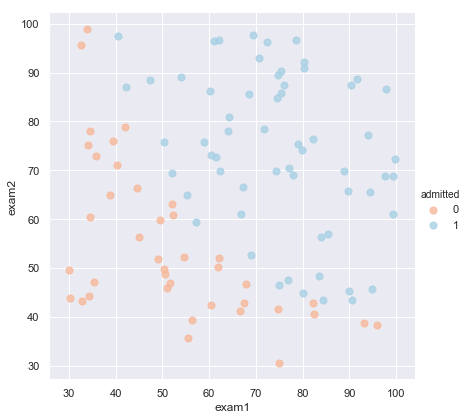

In [8]:
sns.set(context="notebook", style="darkgrid", palette=sns.color_palette("RdBu", 2), color_codes=False) #设置颜料板  color_codes=False  0.9.0 bug

sns.lmplot('exam1', 'exam2', hue='admitted', data=data, 
           height=6, 
           fit_reg=False,  # fit_reg：bool, optional, If True, estimate and plot a regression model relating the x and y variables.
           scatter_kws={"s": 50} # scatter_kws参数控制颜色，透明度，点的大小, s=size
          )
plt.show()#看下数据的样子

In [9]:
def get_X(df):#读取特征
#     """
#     use concat to add intersect feature to avoid side effect
#     not efficient for big dataset though
#     """
    ones = pd.DataFrame({'ones': np.ones(len(df))})#ones是m行1列的dataframe
    data = pd.concat([ones, df], axis=1)  # 合并数据，根据列合并,  ones  exam1  exam2  admitted
    return data.iloc[:, :-1].values  # 这个操作返回 ndarray,不是矩阵, iloc根据index，loc根据索引，不是slice，没有该索引会报错


def get_y(df):#读取标签
#     '''assume the last column is the target'''
    return np.array(df.iloc[:, -1])#df.iloc[:, -1]是指df的最后一列


def normalize_feature(df):
#     """Applies function along input axis(default 0) of DataFrame."""
    return df.apply(lambda column: (column - column.mean()) / column.std())#特征缩放

In [10]:
X = get_X(data)
print(X.shape)

y = get_y(data)
print(y.shape)

(100, 3)
(100,)


# sigmoid 函数
g 代表一个常用的逻辑函数（logistic function）为S形函数（Sigmoid function），公式为： \\[g\left( z \right)=\frac{1}{1+{{e}^{-z}}}\\] 
合起来，我们得到逻辑回归模型的假设函数： 
	\\[{{h}_{\theta }}\left( x \right)=\frac{1}{1+{{e}^{-{{\theta }^{T}}X}}}\\] 


In [11]:
def sigmoid(z):
    # your code here  (appro ~ 1 lines)
    gz = 1 / (1 + np.exp(-z))
    return gz

下面程序会调用上面你写好的函数，并画出sigmoid函数图像。如果你的程序正确，你应该能在下方看到函数图像。

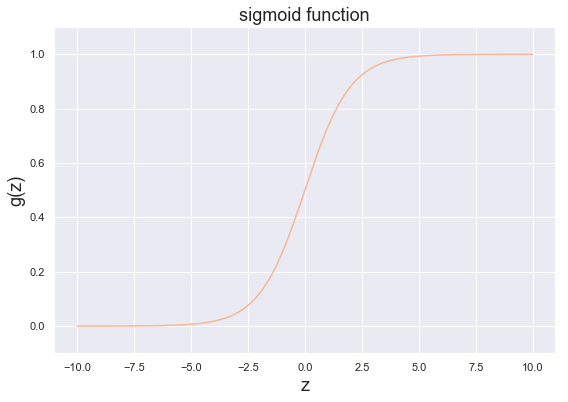

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.arange(-10, 10, step=0.01),
        sigmoid(np.arange(-10, 10, step=0.01)))
ax.set_ylim((-0.1,1.1))
ax.set_xlabel('z', fontsize=18)
ax.set_ylabel('g(z)', fontsize=18)
ax.set_title('sigmoid function', fontsize=18)
plt.show()

# cost function(代价函数)
> * $max(\ell(\theta)) = min(-\ell(\theta))$  
> * choose $-\ell(\theta)$ as the cost function

$$\begin{align}
  & J\left( \theta  \right)=-\frac{1}{m}\sum\limits_{i=1}^{m}{[{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)+\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]} \\ 
 & =\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]} \\ 
\end{align}$$


In [13]:
theta = np.zeros(3) # X(m*n) so theta is n*1
theta

array([0., 0., 0.])

In [14]:
def cost(theta, X, y):
    ''' cost fn is -l(theta) for you to minimize'''
    # your code here  (appro ~ 2 lines)
    return np.mean(-y * np.log(sigmoid(X.dot(theta))) - (1 - y) * np.log(1 - sigmoid(X.dot(theta)))) # 对所有元素求均值
# Hint:X @ theta与X.dot(theta)等价

In [15]:
cost(theta, X, y)

0.6931471805599453

如果你写的代码正确，这里的输出应该是0.6931471805599453

# gradient descent(梯度下降)
* 这是批量梯度下降（batch gradient descent）  
* 转化为向量化计算： $\frac{1}{m} X^T( Sigmoid(X\theta) - y )$
$$\frac{\partial J\left( \theta  \right)}{\partial {{\theta }_{j}}}=\frac{1}{m}\sum\limits_{i=1}^{m}{({{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}})x_{_{j}}^{(i)}}$$

In [16]:
def gradient(theta, X, y):
    # your code here  (appro ~ 2 lines)
    grad = (1 / len(X)) * (X.T @ (sigmoid(X @ theta) - y)) # X.T:3*100 相减：100*1 dot:3*1,即梯度下降theta的三个参数
    return grad

In [17]:
gradient(theta, X, y)

array([ -0.1       , -12.00921659, -11.26284221])

# 拟合参数
> * 这里我使用 [`scipy.optimize.minimize`](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize) 去寻找参数  


In [18]:
import scipy.optimize as opt

In [19]:
# fun ：优化的目标函数
# x0 ：初值，一维数组，shape (n,)
# args ： 元组，可选，额外传递给优化函数的参数
# method：求解的算法，选择TNC则和fmin_tnc()类似
# jac：返回梯度向量的函数
res = opt.minimize(fun=cost, x0=theta, args=(X, y), method='Newton-CG', jac=gradient)

In [20]:
print(res)

     fun: 0.20349770499676162
     jac: array([9.95081849e-06, 5.34555641e-04, 5.25395509e-04])
 message: 'Optimization terminated successfully.'
    nfev: 64
    nhev: 0
     nit: 26
    njev: 217
  status: 0
 success: True
       x: array([-25.15654776,   0.20619328,   0.20143303])


# 用训练集预测和验证

In [21]:
def predict(x, theta):
    # your code here  (appro ~ 2 lines)
    prob = sigmoid(x.dot(theta))
    return (prob >= 0.5).astype(int)  #实现变量类型转换,bool转int

In [22]:
final_theta = res.x
y_pred = predict(X, final_theta)

print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86        40
           1       0.90      0.92      0.91        60

    accuracy                           0.89       100
   macro avg       0.89      0.88      0.88       100
weighted avg       0.89      0.89      0.89       100



# 寻找决策边界
http://stats.stackexchange.com/questions/93569/why-is-logistic-regression-a-linear-classifier
> $X \times \theta = 0$  (this is the line)

In [23]:
print(res.x) # this is final theta , ones  exam1  exam2

[-25.15654776   0.20619328   0.20143303]


In [24]:
coef = -(res.x / res.x[2])  # find the equation
print(coef)

x = np.arange(130, step=0.1)
y = coef[0] + coef[1]*x

[124.88789681  -1.02363192  -1.        ]


In [25]:
data.describe()  # find the range of x and y

,exam1,exam2,admitted
count,100.000000,100.000000,100.000000
mean,65.644274,66.221998,0.600000
std,19.458222,18.582783,0.492366
min,30.058822,30.603263,0.000000
25%,50.919511,48.179205,0.000000
50%,67.032988,67.682381,1.000000
75%,80.212529,79.360605,1.000000
max,99.827858,98.869436,1.000000


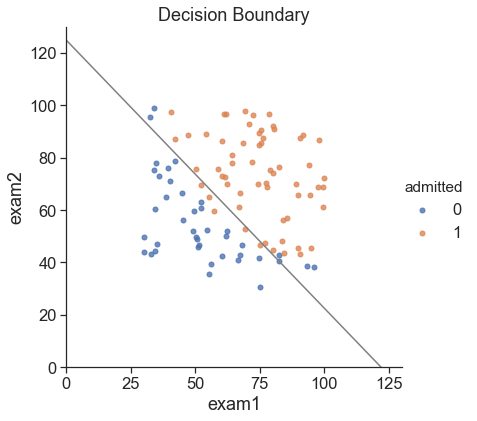

In [26]:
sns.set(context="notebook", style="ticks", font_scale=1.5) # 默认使用notebook上下文 主题 context可以设置输出图片的大小尺寸(scale)

sns.lmplot('exam1', 'exam2', hue='admitted', data=data, 
           height=6, 
           fit_reg=False, 
           scatter_kws={"s": 25}
          )

plt.plot(x, y, 'grey')  # 由上面y = coef[0] + coef[1]*x得到线性划分的直线
plt.xlim(0, 130)
plt.ylim(0, 130)
plt.title('Decision Boundary')
plt.show()

# 3- 正则化逻辑回归

In [27]:
df = pd.read_csv('ex2data2.txt', names=['test1', 'test2', 'accepted'])
df.head()

,test1,test2,accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


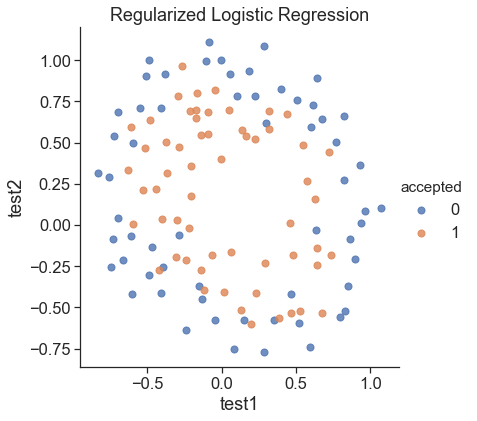

In [28]:
sns.set(context="notebook", style="ticks", font_scale=1.5)

sns.lmplot('test1', 'test2', hue='accepted', data=df, 
           height=6, 
           fit_reg=False, 
           scatter_kws={"s": 50}
          )

plt.title('Regularized Logistic Regression')
plt.show()

# feature mapping（特征映射）

polynomial expansion

```
for i in 0..i
  for p in 0..i:
    output x^(i-p) * y^p
```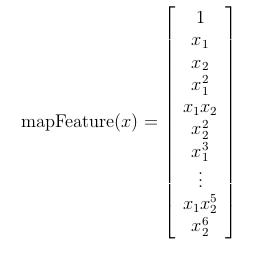

In [58]:
def feature_mapping(x, y, power, as_ndarray=False):
#     """return mapped features as ndarray or dataframe"""

    data = {"f{}{}".format(i - p, p): np.power(x, i - p) * np.power(y, p)
                for i in np.arange(power + 1)
                for p in np.arange(i + 1)
            }

    if as_ndarray:
        return pd.DataFrame(data).as_matrix()
    else:
        return pd.DataFrame(data)


In [59]:
x1 = np.array(df.test1)
x2 = np.array(df.test2)

In [60]:
data = feature_mapping(x1, x2, power=6)  # 最高6次方
print('data',data)
print(data.shape)
data.head()

data      f00       f10       f01       f20       f11       f02           f30  \
0    1.0  0.051267  0.699560  0.002628  0.035864  0.489384  1.347453e-04   
1    1.0 -0.092742  0.684940  0.008601 -0.063523  0.469143 -7.976812e-04   
2    1.0 -0.213710  0.692250  0.045672 -0.147941  0.479210 -9.760555e-03   
3    1.0 -0.375000  0.502190  0.140625 -0.188321  0.252195 -5.273438e-02   
4    1.0 -0.513250  0.465640  0.263426 -0.238990  0.216821 -1.352032e-01   
5    1.0 -0.524770  0.209800  0.275384 -0.110097  0.044016 -1.445130e-01   
6    1.0 -0.398040  0.034357  0.158436 -0.013675  0.001180 -6.306380e-02   
7    1.0 -0.305880 -0.192250  0.093563  0.058805  0.036960 -2.861892e-02   
8    1.0  0.016705 -0.404240  0.000279 -0.006753  0.163410  4.661648e-06   
9    1.0  0.131910 -0.513890  0.017400 -0.067787  0.264083  2.295267e-03   
10   1.0  0.385370 -0.565060  0.148510 -0.217757  0.319293  5.723131e-02   
11   1.0  0.529380 -0.521200  0.280243 -0.275913  0.271649  1.483551e-01   
12   1.

,f00,f10,f01,f20,f11,f02,f30,f21,f12,f03,...,f23,f14,f05,f60,f51,f42,f33,f24,f15,f06
0,1.0,0.051267,0.69956,0.002628,0.035864,0.489384,0.000135,0.001839,0.025089,0.342354,...,0.000900,0.012278,0.167542,1.815630e-08,2.477505e-07,0.000003,0.000046,0.000629,0.008589,0.117206
1,1.0,-0.092742,0.68494,0.008601,-0.063523,0.469143,-0.000798,0.005891,-0.043509,0.321335,...,0.002764,-0.020412,0.150752,6.362953e-07,-4.699318e-06,0.000035,-0.000256,0.001893,-0.013981,0.103256
2,1.0,-0.213710,0.69225,0.045672,-0.147941,0.479210,-0.009761,0.031616,-0.102412,0.331733,...,0.015151,-0.049077,0.158970,9.526844e-05,-3.085938e-04,0.001000,-0.003238,0.010488,-0.033973,0.110047
3,1.0,-0.375000,0.50219,0.140625,-0.188321,0.252195,-0.052734,0.070620,-0.094573,0.126650,...,0.017810,-0.023851,0.031940,2.780914e-03,-3.724126e-03,0.004987,-0.006679,0.008944,-0.011978,0.016040
4,1.0,-0.513250,0.46564,0.263426,-0.238990,0.216821,-0.135203,0.122661,-0.111283,0.100960,...,0.026596,-0.024128,0.021890,1.827990e-02,-1.658422e-02,0.015046,-0.013650,0.012384,-0.011235,0.010193


In [61]:
data.describe()

,f00,f10,f01,f20,f11,f02,f30,f21,f12,f03,...,f23,f14,f05,f60,f51,f42,f33,f24,f15,f06
count,118.0,118.000000,118.000000,118.000000,118.000000,118.000000,1.180000e+02,118.000000,118.000000,118.000000,...,118.000000,1.180000e+02,118.000000,1.180000e+02,118.000000,1.180000e+02,118.000000,1.180000e+02,118.000000,1.180000e+02
mean,1.0,0.054779,0.183102,0.247575,-0.025472,0.301370,5.983333e-02,0.030682,0.015483,0.142350,...,0.018278,4.089084e-03,0.115710,7.837118e-02,-0.000703,1.893340e-02,-0.001705,2.259170e-02,-0.006302,1.257256e-01
std,0.0,0.496654,0.519743,0.248532,0.224075,0.284536,2.746459e-01,0.134706,0.150143,0.326134,...,0.058513,9.993907e-02,0.299092,1.938621e-01,0.058271,3.430092e-02,0.037443,4.346935e-02,0.090621,2.964416e-01
min,1.0,-0.830070,-0.769740,0.000040,-0.484096,0.000026,-5.719317e-01,-0.358121,-0.483743,-0.456071,...,-0.142660,-4.830370e-01,-0.270222,6.472253e-14,-0.203971,2.577297e-10,-0.113448,2.418097e-10,-0.482684,1.795116e-14
25%,1.0,-0.372120,-0.254385,0.043243,-0.178209,0.061086,-5.155632e-02,-0.023672,-0.042980,-0.016492,...,-0.001400,-7.449462e-03,-0.001072,8.086369e-05,-0.006381,1.258285e-04,-0.005749,3.528590e-04,-0.016662,2.298277e-04
50%,1.0,-0.006336,0.213455,0.165397,-0.016521,0.252195,-2.544062e-07,0.006603,-0.000039,0.009734,...,0.001026,-8.972096e-09,0.000444,4.527344e-03,-0.000004,3.387050e-03,-0.000005,3.921378e-03,-0.000020,1.604015e-02
75%,1.0,0.478970,0.646562,0.389925,0.100795,0.464189,1.099616e-01,0.086392,0.079510,0.270310,...,0.021148,2.751341e-02,0.113020,5.932959e-02,0.002104,2.090875e-02,0.001024,2.103622e-02,0.001289,1.001215e-01
max,1.0,1.070900,1.108900,1.146827,0.568307,1.229659,1.228137e+00,0.449251,0.505577,1.363569,...,0.287323,4.012965e-01,1.676725,1.508320e+00,0.250577,2.018260e-01,0.183548,2.556084e-01,0.436209,1.859321e+00


# regularized cost（正则化代价函数）
$$J\left( \theta  \right)=\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]}+\frac{\lambda }{2m}\sum\limits_{j=1}^{n}{\theta _{j}^{2}}$$

In [62]:
theta = np.zeros(data.shape[1])
X = feature_mapping(x1, x2, power=6, as_ndarray=True)
print(X.shape)

y = get_y(df)
print(y.shape)

(118, 28)
(118,)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


In [126]:
def regularized_cost(theta, X, y, l=1):
    # your code here  (appro ~ 3 lines
    theta_j1_to_n = theta[1:]
    regularized_term = (l / (2 * len(X))) * np.power(theta_j1_to_n, 2).sum()
    
    return  cost(theta, X, y) + regularized_term

In [127]:
regularized_cost(theta, X, y, l=1)

0.6931471805599454

因为我们设置theta为0，所以这个正则化代价函数与代价函数的值应该相同

# regularized gradient(正则化梯度)
$$\frac{\partial J\left( \theta  \right)}{\partial {{\theta }_{j}}}=\left( \frac{1}{m}\sum\limits_{i=1}^{m}{\left( {{h}_{\theta }}\left( {{x}^{\left( i \right)}} \right)-{{y}^{\left( i \right)}} \right)}\right)+\frac{\lambda }{m}{{\theta }_{j}}\text{ }\text{             for  j}\ge \text{1}$$

In [128]:
def regularized_gradient(theta, X, y, l=1):
    # your code here  (appro ~ 3 lines)
    theta_j1_to_n = theta[1:]      #不加theta0
    regularized_theta = (l / len(X)) * theta_j1_to_n
    
    regularized_term = np.concatenate([np.array([0]), regularized_theta])
    return gradient(theta, X, y) + regularized_term

In [129]:
regularized_gradient(theta, X, y)

array([8.47457627e-03, 1.87880932e-02, 7.77711864e-05, 5.03446395e-02,
       1.15013308e-02, 3.76648474e-02, 1.83559872e-02, 7.32393391e-03,
       8.19244468e-03, 2.34764889e-02, 3.93486234e-02, 2.23923907e-03,
       1.28600503e-02, 3.09593720e-03, 3.93028171e-02, 1.99707467e-02,
       4.32983232e-03, 3.38643902e-03, 5.83822078e-03, 4.47629067e-03,
       3.10079849e-02, 3.10312442e-02, 1.09740238e-03, 6.31570797e-03,
       4.08503006e-04, 7.26504316e-03, 1.37646175e-03, 3.87936363e-02])

# 拟合参数

In [130]:
import scipy.optimize as opt

In [131]:
print('init cost = {}'.format(regularized_cost(theta, X, y)))

res = opt.minimize(fun=regularized_cost, x0=theta, args=(X, y), method='Newton-CG', jac=regularized_gradient)
res

init cost = 0.6931471805599454


     fun: 0.5290027297127546
     jac: array([-1.61814378e-07, -8.27574188e-09,  6.97518453e-08, -1.74182386e-08,
        1.74831732e-08, -4.46997732e-08,  6.00643960e-09,  1.84342825e-08,
        9.07116325e-09,  8.62945910e-09, -2.64948349e-08,  4.32727305e-09,
       -3.07717893e-08,  1.44474774e-08, -4.06539074e-08, -2.20232893e-09,
        1.18021056e-08, -8.71404286e-09, -3.18325217e-09,  1.05540669e-08,
       -1.04859392e-08, -2.57169050e-08,  3.89336251e-09, -1.35581027e-08,
       -2.19947246e-09, -1.11961167e-08,  7.32418949e-09, -3.32741547e-08])
 message: 'Optimization terminated successfully.'
    nfev: 7
    nhev: 0
     nit: 6
    njev: 66
  status: 0
 success: True
       x: array([ 1.2727395 ,  0.62527144,  1.18108887, -2.01995932, -0.91742437,
       -1.43166389,  0.12400739, -0.36553399, -0.35723868, -0.17513052,
       -1.45815755, -0.05098944, -0.61555727, -0.2747061 , -1.1928176 ,
       -0.24218802, -0.20600554, -0.04473148, -0.27778506, -0.2953773 ,
       -0.4

# 预测

In [132]:
final_theta = res.x
y_pred = predict(X, final_theta)

print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.75      0.82        60
           1       0.78      0.91      0.84        58

    accuracy                           0.83       118
   macro avg       0.84      0.83      0.83       118
weighted avg       0.84      0.83      0.83       118



# 使用不同的 $\lambda$ （这个是常数）
# 画出决策边界
* 我们找到所有满足 $X\times \theta = 0$ 的x
* instead of solving polynomial equation, just create a coridate x,y grid that is dense enough, and find all those $X\times \theta$ that is close enough to 0, then plot them

In [133]:
def draw_boundary(power, l):
#     """
#     power: polynomial power for mapped feature
#     l: lambda constant
#     """
    density = 1000 
    threshhold = 2 * 10**-3

    final_theta = feature_mapped_logistic_regression(power, l)
    x, y = find_decision_boundary(density, power, final_theta, threshhold)

    df = pd.read_csv('ex2data2.txt', names=['test1', 'test2', 'accepted'])
    sns.lmplot('test1', 'test2', hue='accepted', data=df, size=6, fit_reg=False, scatter_kws={"s": 100})

    plt.scatter(x, y, c='R', s=10)
    plt.title('Decision boundary')
    plt.show()

In [134]:
def feature_mapped_logistic_regression(power, l):
#     """for drawing purpose only.. not a well generealize logistic regression
#     power: int
#         raise x1, x2 to polynomial power
#     l: int
#         lambda constant for regularization term
#     """
    df = pd.read_csv('ex2data2.txt', names=['test1', 'test2', 'accepted'])
    x1 = np.array(df.test1)
    x2 = np.array(df.test2)
    y = get_y(df)

    X = feature_mapping(x1, x2, power, as_ndarray=True)
    theta = np.zeros(X.shape[1])

    res = opt.minimize(fun=regularized_cost,
                       x0=theta,
                       args=(X, y, l),
                       method='TNC',
                       jac=regularized_gradient)
    final_theta = res.x
    print('final_theta:',final_theta)

    return final_theta

In [135]:
def find_decision_boundary(density, power, theta, threshhold):
    t1 = np.linspace(-1, 1.5, density)  #通过1000*1000的密集点阵去拟合28项式，寻找和阈值接近的“正确答案”，即为边界点
    t2 = np.linspace(-1, 1.5, density)

    cordinates = [(x, y) for x in t1 for y in t2]
    x_cord, y_cord = zip(*cordinates) # zip函数打包生成元组并解包
    mapped_cord = feature_mapping(x_cord, y_cord, power)  # this is a dataframe

    inner_product = mapped_cord.as_matrix() @ theta

    decision = mapped_cord[np.abs(inner_product) < threshhold]

    return decision.f10, decision.f01
#寻找决策边界函数

# 改变$\lambda$的值，查看效果（选做）

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


final_theta: [ 1.27271027  0.62529965  1.18111686 -2.01987399 -0.91743189 -1.43166929
  0.12393227 -0.36553118 -0.35725403 -0.17516291 -1.4581701  -0.05098418
 -0.61558551 -0.27469165 -1.19271298 -0.2421784  -0.20603295 -0.04466179
 -0.27778953 -0.29539513 -0.45645982 -1.04319155  0.02779373 -0.29244873
  0.01555761 -0.32742407 -0.14389151 -0.92467487]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


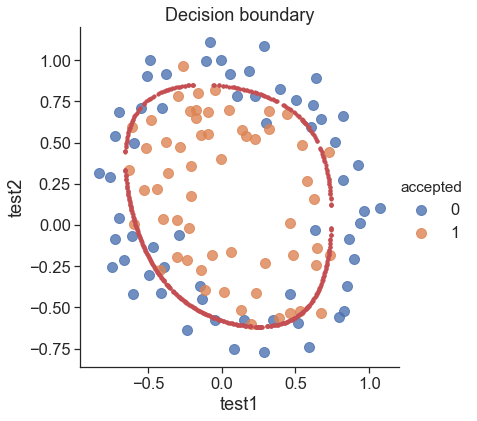

In [136]:
draw_boundary(power=6, l=1)     #set lambda = 1

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


final_theta: [  11.23163124   11.84281506    6.23581329 -118.099164    -50.78353716
  -42.5465643  -102.11790956  -84.755192    -21.84776193    4.51443267
  433.02415762  356.86019742  453.53296381  143.3284536    49.14611934
  195.44443399  265.68549297  294.56610863  200.30923312   44.48513938
   -6.09671118 -520.10173336 -631.07022253 -865.64386968 -618.92702646
 -656.08054312 -211.39193134  -31.07291688]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


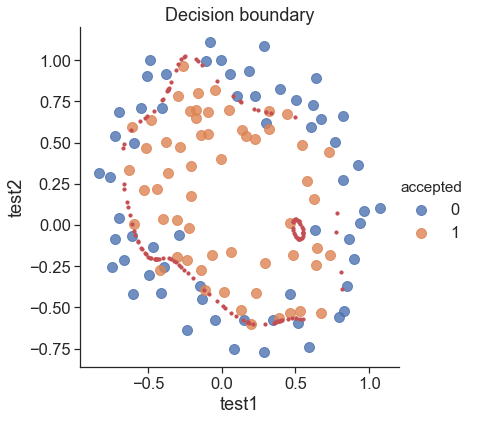

In [137]:
draw_boundary(power=6, l=0)  # set lambda < 0.1

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


final_theta: [ 0.02187847 -0.0174817   0.00571065 -0.05516901 -0.01314874 -0.03859873
 -0.01846356 -0.00773219 -0.00892429 -0.02280461 -0.04343846 -0.00235623
 -0.01415612 -0.00349507 -0.04143595 -0.02100593 -0.00471917 -0.00359131
 -0.00632226 -0.0050244  -0.03197683 -0.03416334 -0.00107629 -0.00702615
 -0.00038507 -0.0079823  -0.00154779 -0.04108683]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


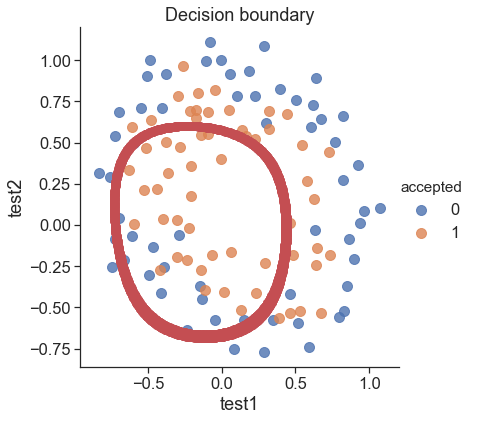

In [138]:
draw_boundary(power=6, l=100)  # set lambda > 10